# Project 3: DCGANs
#### Malachi Eberly

This code was written using a custom GPT powered by ChatGPT 4

In [25]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

## 1. Dataset Preparation

In [26]:
transform = transforms.Compose([
    transforms.Resize(64),  # Resize images to 64x64
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images to [-1, 1]
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class AnimeFacesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image

# Usage
dataset = AnimeFacesDataset(root_dir='data', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


## 2. DCGAN Architecture

#### Generator

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


#### Discriminator

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Output is a single scalar per image
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


## 3. Loss and Optimizer

In [29]:
# Initialize Generator and Discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.02.
generator.apply(weights_init)
discriminator.apply(weights_init)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


## 4. Training Loop

Starting Training Loop...
[0/100][0/169]	Loss_D: 0.0320	Loss_G: 9.5425	D(x): 0.9770	D(G(z1)): 0.0015 / D(G(z2)): 0.0002
[0/100][50/169]	Loss_D: 2.9248	Loss_G: 20.7181	D(x): 0.9503	D(G(z1)): 0.8238 / D(G(z2)): 0.0000
[0/100][100/169]	Loss_D: 0.4692	Loss_G: 5.6414	D(x): 0.8922	D(G(z1)): 0.2317 / D(G(z2)): 0.0073
[0/100][150/169]	Loss_D: 0.4333	Loss_G: 3.7874	D(x): 0.8477	D(G(z1)): 0.1282 / D(G(z2)): 0.0315


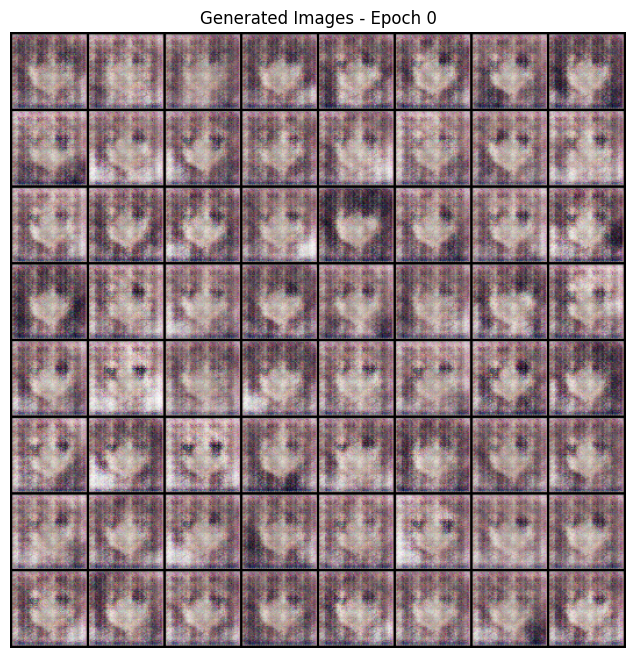

[1/100][0/169]	Loss_D: 0.6602	Loss_G: 7.4878	D(x): 0.8263	D(G(z1)): 0.3206 / D(G(z2)): 0.0015
[1/100][50/169]	Loss_D: 0.4279	Loss_G: 3.8216	D(x): 0.8635	D(G(z1)): 0.1518 / D(G(z2)): 0.0474
[1/100][100/169]	Loss_D: 0.9252	Loss_G: 9.6894	D(x): 0.8949	D(G(z1)): 0.4854 / D(G(z2)): 0.0002
[1/100][150/169]	Loss_D: 0.8176	Loss_G: 8.3713	D(x): 0.9259	D(G(z1)): 0.4419 / D(G(z2)): 0.0006
[2/100][0/169]	Loss_D: 0.6022	Loss_G: 5.8000	D(x): 0.8320	D(G(z1)): 0.2380 / D(G(z2)): 0.0051
[2/100][50/169]	Loss_D: 0.8783	Loss_G: 7.8377	D(x): 0.8829	D(G(z1)): 0.4421 / D(G(z2)): 0.0010
[2/100][100/169]	Loss_D: 0.9657	Loss_G: 9.4827	D(x): 0.9867	D(G(z1)): 0.5281 / D(G(z2)): 0.0004
[2/100][150/169]	Loss_D: 0.4682	Loss_G: 7.6510	D(x): 0.8736	D(G(z1)): 0.2377 / D(G(z2)): 0.0008
[3/100][0/169]	Loss_D: 0.2845	Loss_G: 6.8967	D(x): 0.8852	D(G(z1)): 0.1092 / D(G(z2)): 0.0030
[3/100][50/169]	Loss_D: 0.5343	Loss_G: 5.7949	D(x): 0.8632	D(G(z1)): 0.2551 / D(G(z2)): 0.0071
[3/100][100/169]	Loss_D: 0.5305	Loss_G: 4.3180	D(

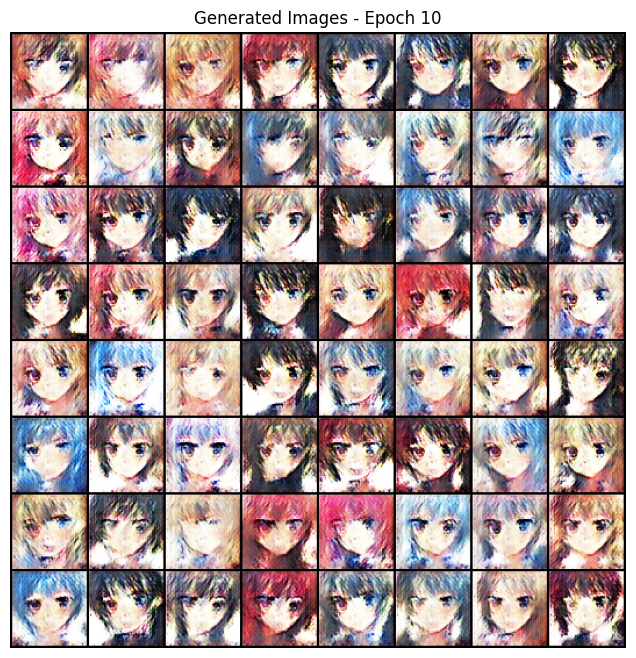

[11/100][0/169]	Loss_D: 0.4751	Loss_G: 2.8187	D(x): 0.7339	D(G(z1)): 0.0533 / D(G(z2)): 0.0924
[11/100][50/169]	Loss_D: 0.2814	Loss_G: 4.8390	D(x): 0.9046	D(G(z1)): 0.1398 / D(G(z2)): 0.0125
[11/100][100/169]	Loss_D: 0.5046	Loss_G: 8.1855	D(x): 0.9861	D(G(z1)): 0.3181 / D(G(z2)): 0.0007
[11/100][150/169]	Loss_D: 0.4541	Loss_G: 8.3891	D(x): 0.9843	D(G(z1)): 0.3214 / D(G(z2)): 0.0005
[12/100][0/169]	Loss_D: 0.4296	Loss_G: 7.2181	D(x): 0.9552	D(G(z1)): 0.2552 / D(G(z2)): 0.0023
[12/100][50/169]	Loss_D: 0.4170	Loss_G: 9.3790	D(x): 0.9700	D(G(z1)): 0.2606 / D(G(z2)): 0.0002
[12/100][100/169]	Loss_D: 0.4949	Loss_G: 9.1970	D(x): 0.9809	D(G(z1)): 0.3346 / D(G(z2)): 0.0002
[12/100][150/169]	Loss_D: 2.3703	Loss_G: 4.8017	D(x): 0.2088	D(G(z1)): 0.0005 / D(G(z2)): 0.0359
[13/100][0/169]	Loss_D: 0.2492	Loss_G: 5.6296	D(x): 0.9197	D(G(z1)): 0.1275 / D(G(z2)): 0.0071
[13/100][50/169]	Loss_D: 0.3188	Loss_G: 4.4086	D(x): 0.8283	D(G(z1)): 0.0683 / D(G(z2)): 0.0261
[13/100][100/169]	Loss_D: 0.6182	Loss_G

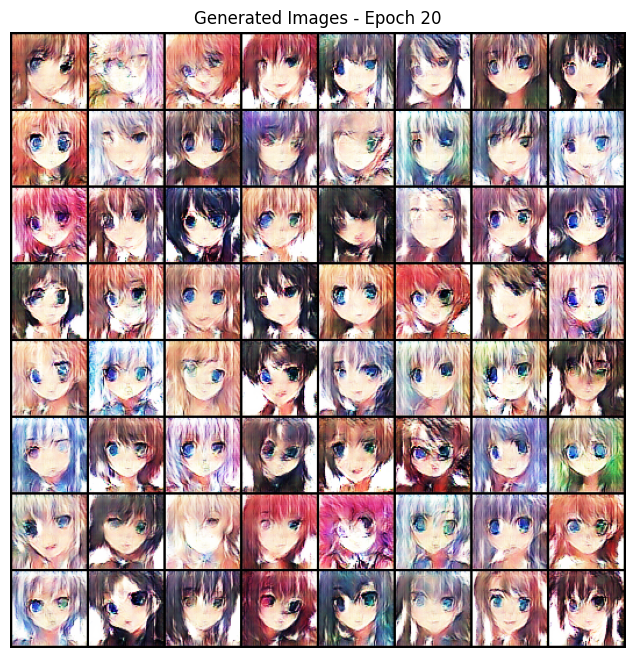

[21/100][0/169]	Loss_D: 0.5649	Loss_G: 4.3390	D(x): 0.6774	D(G(z1)): 0.0042 / D(G(z2)): 0.0368
[21/100][50/169]	Loss_D: 3.4518	Loss_G: 2.1326	D(x): 0.0711	D(G(z1)): 0.0001 / D(G(z2)): 0.2535
[21/100][100/169]	Loss_D: 1.0326	Loss_G: 10.2072	D(x): 0.9919	D(G(z1)): 0.4896 / D(G(z2)): 0.0002
[21/100][150/169]	Loss_D: 0.7868	Loss_G: 2.0371	D(x): 0.5678	D(G(z1)): 0.0149 / D(G(z2)): 0.2069
[22/100][0/169]	Loss_D: 0.3914	Loss_G: 3.5528	D(x): 0.7951	D(G(z1)): 0.0976 / D(G(z2)): 0.0495
[22/100][50/169]	Loss_D: 0.6527	Loss_G: 3.8070	D(x): 0.6135	D(G(z1)): 0.0039 / D(G(z2)): 0.0448
[22/100][100/169]	Loss_D: 0.4446	Loss_G: 2.7209	D(x): 0.7412	D(G(z1)): 0.0673 / D(G(z2)): 0.1059
[22/100][150/169]	Loss_D: 0.2967	Loss_G: 4.0712	D(x): 0.8566	D(G(z1)): 0.1021 / D(G(z2)): 0.0329
[23/100][0/169]	Loss_D: 0.8079	Loss_G: 8.5623	D(x): 0.9434	D(G(z1)): 0.4423 / D(G(z2)): 0.0005
[23/100][50/169]	Loss_D: 0.4037	Loss_G: 6.6547	D(x): 0.9436	D(G(z1)): 0.2582 / D(G(z2)): 0.0025
[23/100][100/169]	Loss_D: 0.4866	Loss_

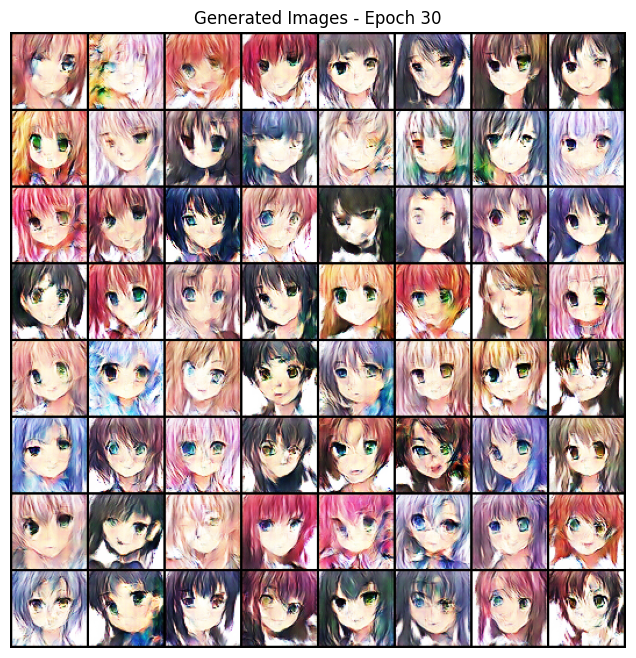

[31/100][0/169]	Loss_D: 0.4417	Loss_G: 2.4958	D(x): 0.7250	D(G(z1)): 0.0387 / D(G(z2)): 0.1190
[31/100][50/169]	Loss_D: 0.2285	Loss_G: 3.9005	D(x): 0.8968	D(G(z1)): 0.0809 / D(G(z2)): 0.0407
[31/100][100/169]	Loss_D: 0.3227	Loss_G: 4.4641	D(x): 0.8677	D(G(z1)): 0.1342 / D(G(z2)): 0.0220
[31/100][150/169]	Loss_D: 0.2707	Loss_G: 6.1578	D(x): 0.9420	D(G(z1)): 0.1618 / D(G(z2)): 0.0044
[32/100][0/169]	Loss_D: 0.4118	Loss_G: 3.7100	D(x): 0.8157	D(G(z1)): 0.1464 / D(G(z2)): 0.0421
[32/100][50/169]	Loss_D: 0.2321	Loss_G: 3.7386	D(x): 0.9163	D(G(z1)): 0.1208 / D(G(z2)): 0.0384
[32/100][100/169]	Loss_D: 0.2142	Loss_G: 3.6185	D(x): 0.8684	D(G(z1)): 0.0490 / D(G(z2)): 0.0415
[32/100][150/169]	Loss_D: 0.3512	Loss_G: 4.7199	D(x): 0.8138	D(G(z1)): 0.0876 / D(G(z2)): 0.0218
[33/100][0/169]	Loss_D: 0.4635	Loss_G: 5.3682	D(x): 0.8964	D(G(z1)): 0.2517 / D(G(z2)): 0.0080
[33/100][50/169]	Loss_D: 0.2608	Loss_G: 3.5779	D(x): 0.8612	D(G(z1)): 0.0838 / D(G(z2)): 0.0484
[33/100][100/169]	Loss_D: 0.3338	Loss_G

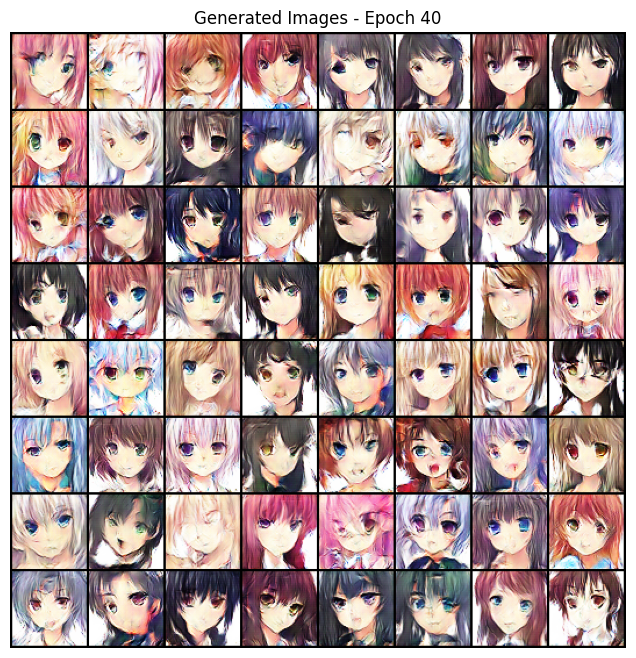

[41/100][0/169]	Loss_D: 0.2607	Loss_G: 4.8822	D(x): 0.9617	D(G(z1)): 0.1699 / D(G(z2)): 0.0166
[41/100][50/169]	Loss_D: 0.4564	Loss_G: 5.7729	D(x): 0.9323	D(G(z1)): 0.2754 / D(G(z2)): 0.0061
[41/100][100/169]	Loss_D: 0.2208	Loss_G: 2.7974	D(x): 0.8674	D(G(z1)): 0.0596 / D(G(z2)): 0.0929
[41/100][150/169]	Loss_D: 0.1737	Loss_G: 5.1472	D(x): 0.9426	D(G(z1)): 0.0981 / D(G(z2)): 0.0107
[42/100][0/169]	Loss_D: 0.5697	Loss_G: 7.3985	D(x): 0.9770	D(G(z1)): 0.3678 / D(G(z2)): 0.0012
[42/100][50/169]	Loss_D: 0.9905	Loss_G: 0.5795	D(x): 0.4552	D(G(z1)): 0.0033 / D(G(z2)): 0.6328
[42/100][100/169]	Loss_D: 0.3241	Loss_G: 4.1677	D(x): 0.8863	D(G(z1)): 0.1512 / D(G(z2)): 0.0284
[42/100][150/169]	Loss_D: 0.2023	Loss_G: 3.3146	D(x): 0.8719	D(G(z1)): 0.0498 / D(G(z2)): 0.0631
[43/100][0/169]	Loss_D: 0.2396	Loss_G: 3.5552	D(x): 0.8566	D(G(z1)): 0.0612 / D(G(z2)): 0.0489
[43/100][50/169]	Loss_D: 0.1611	Loss_G: 4.1423	D(x): 0.9084	D(G(z1)): 0.0546 / D(G(z2)): 0.0269
[43/100][100/169]	Loss_D: 0.7510	Loss_G

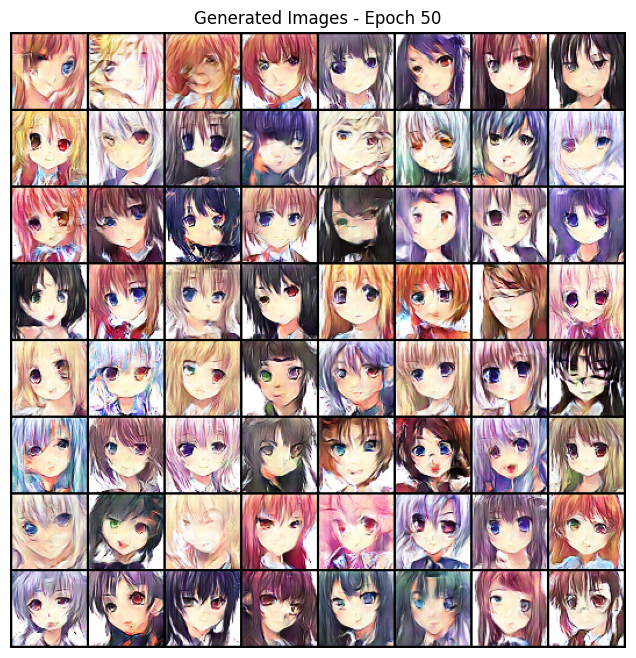

[51/100][0/169]	Loss_D: 0.2319	Loss_G: 2.7434	D(x): 0.8644	D(G(z1)): 0.0674 / D(G(z2)): 0.1093
[51/100][50/169]	Loss_D: 0.2978	Loss_G: 4.0874	D(x): 0.9084	D(G(z1)): 0.1591 / D(G(z2)): 0.0275
[51/100][100/169]	Loss_D: 0.1539	Loss_G: 3.6470	D(x): 0.9435	D(G(z1)): 0.0850 / D(G(z2)): 0.0387
[51/100][150/169]	Loss_D: 0.3402	Loss_G: 3.1938	D(x): 0.9007	D(G(z1)): 0.1746 / D(G(z2)): 0.0703
[52/100][0/169]	Loss_D: 0.2731	Loss_G: 4.4314	D(x): 0.9370	D(G(z1)): 0.1648 / D(G(z2)): 0.0188
[52/100][50/169]	Loss_D: 0.1317	Loss_G: 3.3333	D(x): 0.9215	D(G(z1)): 0.0411 / D(G(z2)): 0.0535
[52/100][100/169]	Loss_D: 0.1888	Loss_G: 4.3974	D(x): 0.9609	D(G(z1)): 0.1240 / D(G(z2)): 0.0194
[52/100][150/169]	Loss_D: 0.9071	Loss_G: 6.2869	D(x): 0.7909	D(G(z1)): 0.3864 / D(G(z2)): 0.0040
[53/100][0/169]	Loss_D: 0.3175	Loss_G: 3.5038	D(x): 0.8625	D(G(z1)): 0.1279 / D(G(z2)): 0.0526
[53/100][50/169]	Loss_D: 0.2197	Loss_G: 4.2785	D(x): 0.9567	D(G(z1)): 0.1465 / D(G(z2)): 0.0213
[53/100][100/169]	Loss_D: 1.0409	Loss_G

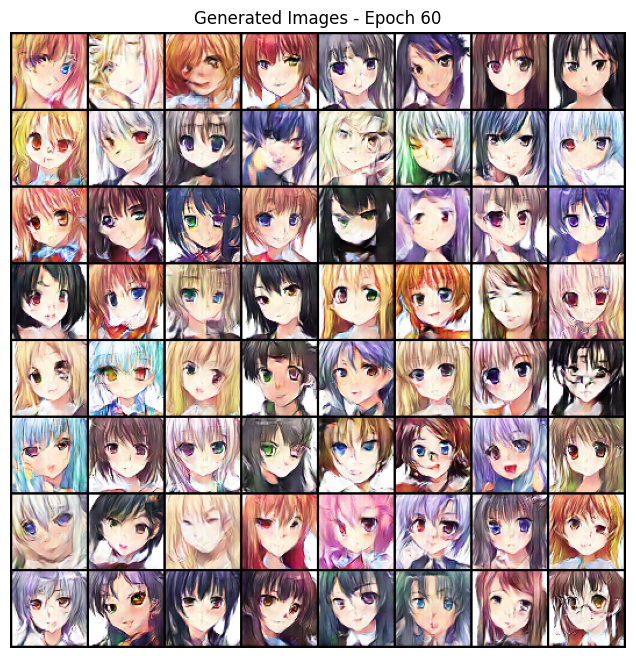

[61/100][0/169]	Loss_D: 0.3732	Loss_G: 6.0222	D(x): 0.9711	D(G(z1)): 0.2352 / D(G(z2)): 0.0053
[61/100][50/169]	Loss_D: 0.1548	Loss_G: 3.9712	D(x): 0.9273	D(G(z1)): 0.0678 / D(G(z2)): 0.0340
[61/100][100/169]	Loss_D: 0.2666	Loss_G: 5.9144	D(x): 0.9724	D(G(z1)): 0.1934 / D(G(z2)): 0.0042
[61/100][150/169]	Loss_D: 0.2638	Loss_G: 5.6077	D(x): 0.7948	D(G(z1)): 0.0051 / D(G(z2)): 0.0094
[62/100][0/169]	Loss_D: 0.9137	Loss_G: 1.8501	D(x): 0.6521	D(G(z1)): 0.2286 / D(G(z2)): 0.2591
[62/100][50/169]	Loss_D: 0.1730	Loss_G: 4.6545	D(x): 0.9603	D(G(z1)): 0.1138 / D(G(z2)): 0.0162
[62/100][100/169]	Loss_D: 0.1526	Loss_G: 3.4508	D(x): 0.8975	D(G(z1)): 0.0355 / D(G(z2)): 0.0536
[62/100][150/169]	Loss_D: 0.1587	Loss_G: 3.3823	D(x): 0.9311	D(G(z1)): 0.0735 / D(G(z2)): 0.0540
[63/100][0/169]	Loss_D: 0.8514	Loss_G: 2.2647	D(x): 0.5177	D(G(z1)): 0.0046 / D(G(z2)): 0.1659
[63/100][50/169]	Loss_D: 0.1628	Loss_G: 3.7270	D(x): 0.9087	D(G(z1)): 0.0552 / D(G(z2)): 0.0381
[63/100][100/169]	Loss_D: 0.1247	Loss_G

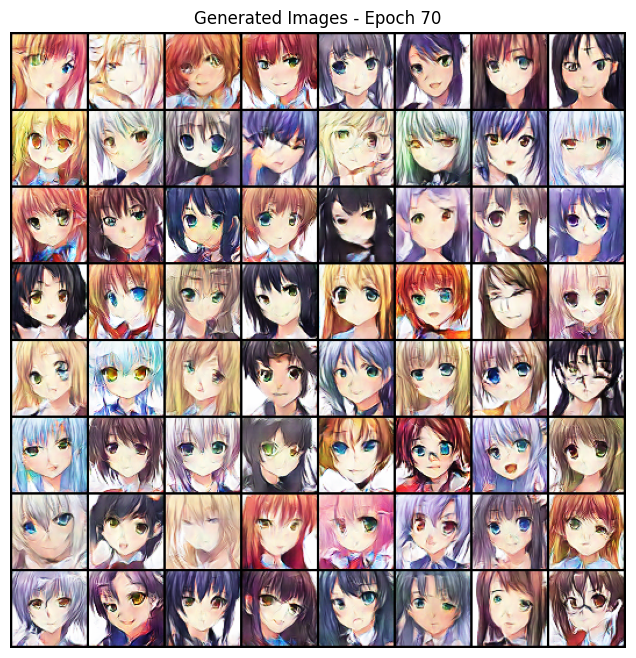

[71/100][0/169]	Loss_D: 0.1385	Loss_G: 3.6325	D(x): 0.8999	D(G(z1)): 0.0241 / D(G(z2)): 0.0536
[71/100][50/169]	Loss_D: 0.1117	Loss_G: 4.8825	D(x): 0.9501	D(G(z1)): 0.0536 / D(G(z2)): 0.0130
[71/100][100/169]	Loss_D: 0.1100	Loss_G: 3.8440	D(x): 0.9617	D(G(z1)): 0.0640 / D(G(z2)): 0.0338
[71/100][150/169]	Loss_D: 0.0875	Loss_G: 4.6659	D(x): 0.9594	D(G(z1)): 0.0412 / D(G(z2)): 0.0186
[72/100][0/169]	Loss_D: 0.1186	Loss_G: 4.8710	D(x): 0.9904	D(G(z1)): 0.0952 / D(G(z2)): 0.0151
[72/100][50/169]	Loss_D: 0.0696	Loss_G: 4.8748	D(x): 0.9853	D(G(z1)): 0.0506 / D(G(z2)): 0.0134
[72/100][100/169]	Loss_D: 0.2326	Loss_G: 3.1921	D(x): 0.9113	D(G(z1)): 0.1124 / D(G(z2)): 0.0730
[72/100][150/169]	Loss_D: 0.1755	Loss_G: 3.7769	D(x): 0.9053	D(G(z1)): 0.0590 / D(G(z2)): 0.0397
[73/100][0/169]	Loss_D: 0.2352	Loss_G: 4.9786	D(x): 0.8408	D(G(z1)): 0.0342 / D(G(z2)): 0.0130
[73/100][50/169]	Loss_D: 0.1798	Loss_G: 4.3045	D(x): 0.9085	D(G(z1)): 0.0608 / D(G(z2)): 0.0237
[73/100][100/169]	Loss_D: 0.1099	Loss_G

KeyboardInterrupt: 

In [33]:
# Number of epochs
num_epochs = 100

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the DataLoader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        ## Train with all-real batch
        discriminator.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(0.)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ############################
        generator.zero_grad()
        label.fill_(1.)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z1)): %.4f / D(G(z2)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

    # Check how the generator is doing by saving G's output on fixed_noise every 10 epochs
    if epoch % 10 == 0 or epoch == num_epochs-1:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        # Display the generated images
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Generated Images - Epoch {}".format(epoch))
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.pause(0.1)  # pause a bit so that plots are updated

plt.show()